In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from pylab import rcParams
import seaborn as sns
from datetime import datetime
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.forecasting.tbats import TBATS

In [77]:
rcParams["figure.figsize"] = 15, 7
sns.set(palette="Set2", font_scale=1.3)

https://www.kaggle.com/c/demand-forecasting-kernels-only/overview прогнозирование спроса на товары

Данные содержат следующие колонки: 
* date &mdash; дата;
* store &mdash; ID магазина;
* item &mdash; ID товара;
* sales &mdash; количество продаж.

В датасете содержится информация про 50 товаров в 10 магазинах за 5 лет.

In [78]:
# https://www.kaggle.com/c/demand-forecasting-kernels-only/overview
fname = 'train.csv'

In [79]:
data = pd.read_csv(fname, parse_dates=["date"])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Выберем первый магазин и первый товар и будем предсказывать спрос на выбранный товар в данном магазине, используя последний год для сравнения моделей.

In [5]:
# Задаем магазин и продукт
store, item = 1, 1

# Выделяем только те данные, которые относятся к данному магазину и продукту
data = data[(data["store"] == store) & (data["item"] == item)]

# Дату уставнавливаем как индекс
data = data.set_index("date")

# Выделяем данные о продажах
data = data["sales"]

### Данные
Разделим данные на трейн и тест для обучения и тестирования результатов соотвественно. На тест отправляем данные за последний год.

In [6]:
test_size = 365
data_train = data.iloc[:-test_size]
data_test = data.iloc[-test_size:]

Визуализируем полученные данные.

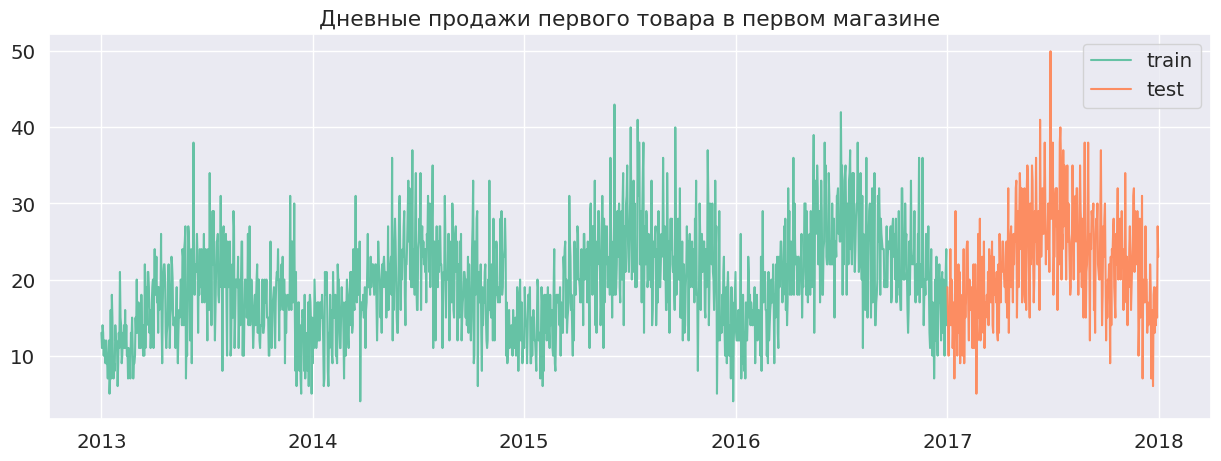

In [7]:
plt.figure(figsize=(15, 5))
plt.title("Дневные продажи первого товара в первом магазине")
plt.plot(data_train, label="train")
plt.plot(data_test, label="test")
plt.legend();

Видно, что данные обладают годичной сезонностью. Посмотрим теперь, есть ли недельная сезонность.

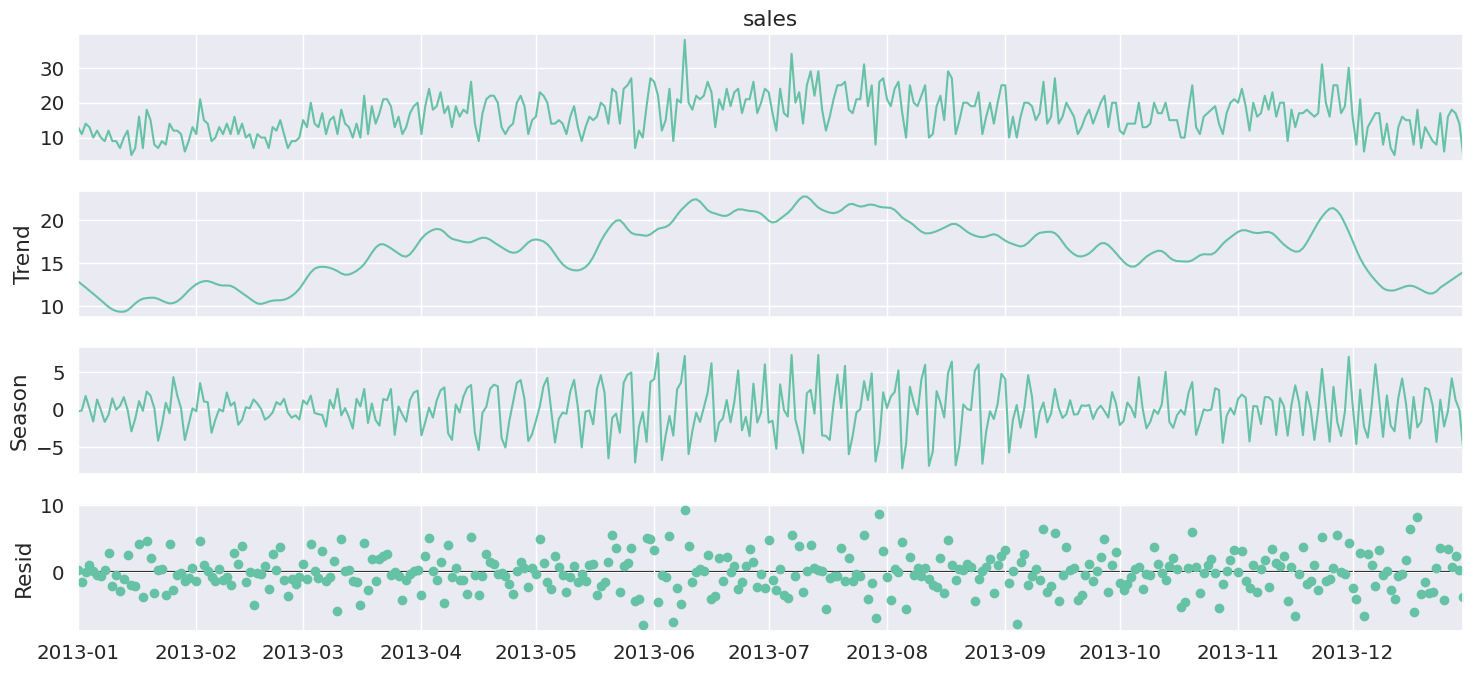

In [8]:
result = STL(data_train[:364], period=7).fit()
result.plot();

Недельная сезонность есть, но с некоторыми шумами.

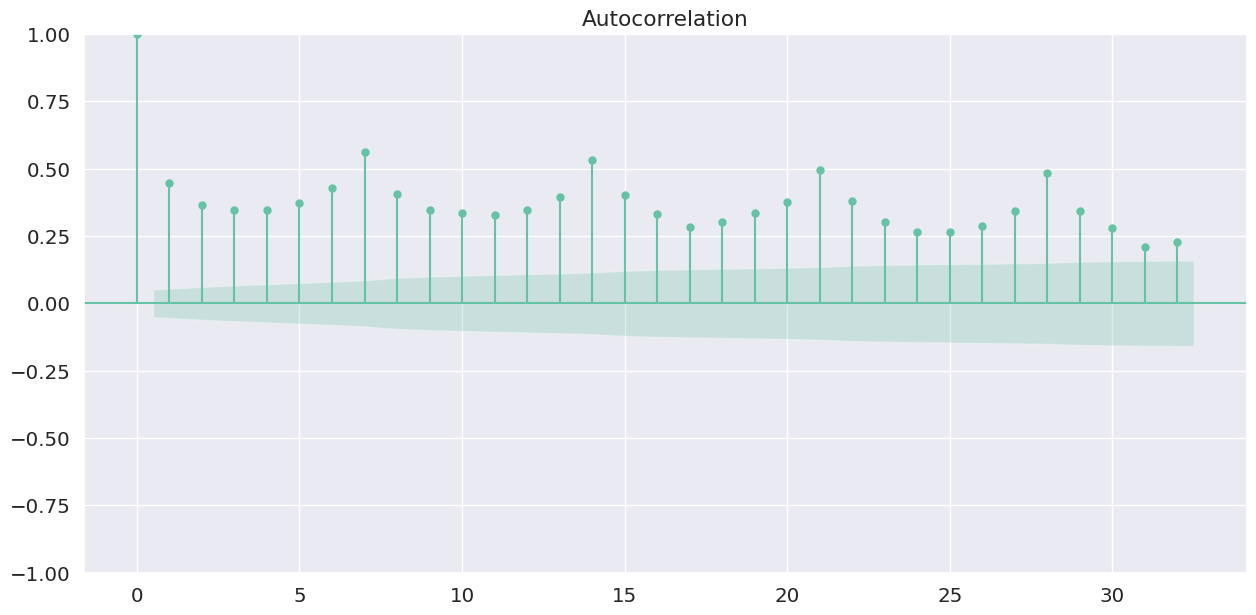

In [81]:
plot_acf(data_train);

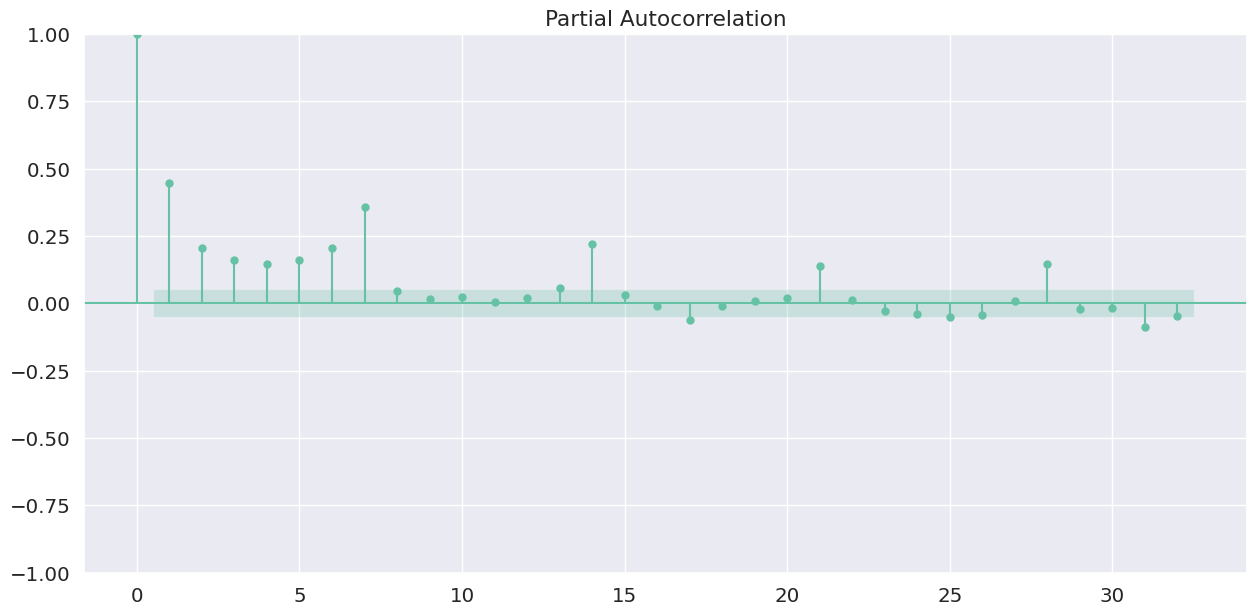

In [83]:
plot_pacf(data_train);

### Метрики
Зададим метрики, по которым мы будем определять, какая из моделей лучше: MSE, MAE, MAPE.

In [9]:
compare_table = None

In [10]:
def add_results_in_comparison_table(
    method: str, y_true, y_forecast
) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table
    с результатами текущей модели.

    Если ранее модель была уже добавлена в таблицу,
    то старая строчка перезапишется на новую.

    Параметры:
    - method: имя модели.
    - y_true: истинные значения.
    - y_forecast: предсказанные значения.
    """

    # Обращаемся к глобальной переменной
    global compare_table

    # Считаем метрики
    result_row = {
        "method": method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(
            y_true=y_true, y_pred=y_forecast
        ),
    }

    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table["method"]):
            compare_table = compare_table[compare_table["method"] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

### Простая модель / baseline
Для начала сделаем некоторую эмпирическую модель. Она будет считать среднее за каждый год с учетом дней недели. Полученное среднее как раз будет являться прогнозом на будущее.

In [11]:
temp_data = pd.DataFrame(data_train)

# выделяем день недели
temp_data["weekofyear"] = data_train.index.isocalendar().week
temp_data["dayofweek"] = data_train.index.dayofweek

# считаем среднее за каждый год с учетом дня недели
mean_sales = temp_data.groupby(["weekofyear", "dayofweek"])["sales"].mean()
display(mean_sales)

weekofyear  dayofweek
1           0             8.666667
            1            12.750000
            2            12.000000
            3            12.750000
            4            13.750000
                           ...    
53          2            15.000000
            3            18.000000
            4            21.000000
            5            13.000000
            6            12.000000
Name: sales, Length: 371, dtype: float64

In [12]:
simple_prediction = []
for index in data_test.index:
    simple_prediction.append(
        mean_sales.loc[(index.weekofyear, index.dayofweek)]
    )

Отобразим полученные результаты.

In [13]:
def plot_results(y_to_train, y_to_test, y_forecast):
    """
    Функция для визуализации временного ряда и предсказания.

    Параметры:
        - y_to_train: pd.Series
            Временной ряд, на котором обучалась модель.
        - y_to_test: pd.Series
            Временной ряд, который предсказывает модель.
        - y_forecast: array
            Предсказания модели.
        - plot_conf_int: bool
            Надо ли строить предсказательного интервал.
        - left_bound: array
            Левая граница предсказательного интервала.
        - right_bound: array
            Правая граница предсказательного интервала.
    """

    plt.figure(figsize=(15, 5))
    plt.title("Дневные продажи объекта 1 в магазине 1", fontsize=15)
    plt.plot(y_to_train, label="train")
    plt.plot(y_to_test, label="test")
    plt.plot(y_to_test.index, y_forecast, label="prediction")
    plt.legend()
    plt.show()

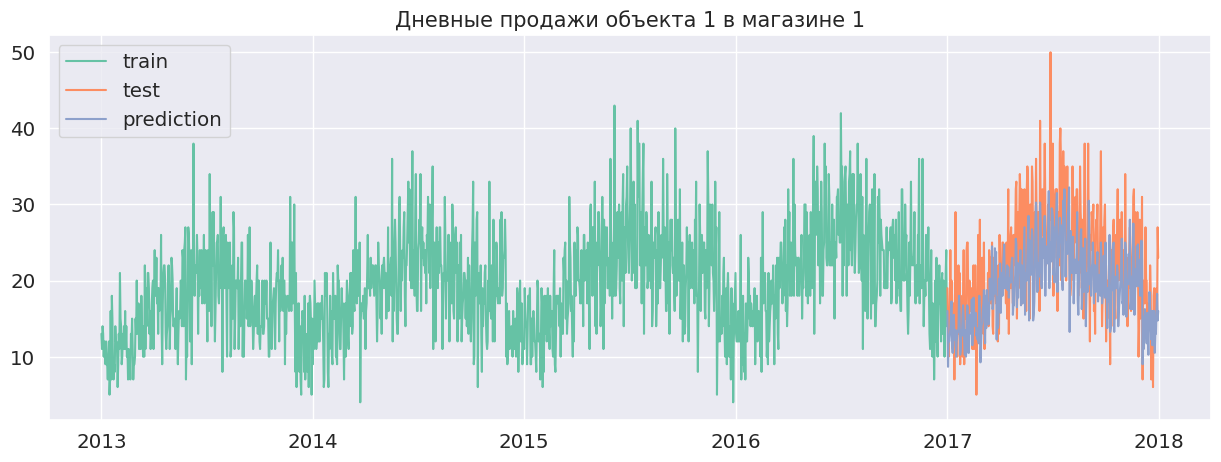

In [14]:
plot_results(data_train, data_test, simple_prediction)

Для простой модели выглядит очень даже неплохо. Посчитаем метрики и сохраним результат.

In [15]:
add_results_in_comparison_table(
    "Simple mean model", data_test, simple_prediction
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949


### Работа с признаками 1
Далее мы будем работать со стандартными моделями регрессии. Вспомним, какие признаки нужно подавать в модель, чтобы она могла работать с временным рядом.
 ____
 

Для начала преобразуем дату, выделив из даты день, месяц, год и т.д. Для этого будем использовать функцию ниже.

In [16]:
def create_date_features(date):
    """Создает фичи из даты"""

    row = {}
    row["dayofweek"] = date.dayofweek
    row["quarter"] = date.quarter
    row["month"] = date.month
    row["year"] = date.year
    row["dayofyear"] = date.dayofyear
    row["dayofmonth"] = date.day
    row["weekofyear"] = date.weekofyear
    return row

С помощью следующей функции создадим датасет для обучения.

In [17]:
def create_only_date_train_features(y_series):
    """
    Создает обучающий датасет из признаков, полученных из дат для y_series
    """

    time_features = pd.DataFrame(
        [create_date_features(date) for date in y_series.index]
    )
    return time_features, y_series

In [18]:
X_train, y_train = create_only_date_train_features(data_train)
display(X_train.head())
display(y_train.head())

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,1,1,2013,1,1,1
1,2,1,1,2013,2,2,1
2,3,1,1,2013,3,3,1
3,4,1,1,2013,4,4,1
4,5,1,1,2013,5,5,1


date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

Подумаем о том, как мы будем предсказывать в будущем. Мы рассматривали три стратегии. Какие это были стратегии?
___

В данном случае опробуем рекурсивную стратегию. Она не требует большого количества моделей, как другие стратегии, однако обычно точность у таких моделей оказывается немного хуже.

In [19]:
def recursive_prediction(
    model, test_dates, y_to_train, features_creation_function
):
    """
    Функция для рекурсивного предсказания для дат,
    указанных в test_dates.

    Параметры:
        - model
            МЛ-модель.
        - test_dates
            массив с датами, в которые надо сделать предсказания.
        - features_creation_function
            функция для создания тестовых признаков
    """
    predictions = []
    previous_y = list(y_to_train)

    for date in test_dates:
        row = features_creation_function(date, previous_y)
        curr_test = pd.DataFrame([row])
        curr_prediction = model.predict(curr_test)[0]
        previous_y.append(curr_prediction)
        predictions.append(curr_prediction)
    return np.array(predictions)

Попробуем несколько моделей для решения нашей задачи регрессии. Вспомним, какие модели бывают.
___



Попробуем метод `RandomForest`. Обучим модель.

In [20]:
%%time
random_forest = RandomForestRegressor(n_estimators=300, random_state=42)
random_forest.fit(X_train, y_train)

CPU times: user 751 ms, sys: 16.9 ms, total: 767 ms
Wall time: 767 ms


RandomForestRegressor(n_estimators=300, random_state=42)

Получим предсказания.

In [21]:
random_forest_predictions = recursive_prediction(
    random_forest,
    data_test.index,
    data_train,
    lambda date, previous_y: create_date_features(date),
)

Отобразим результаты.

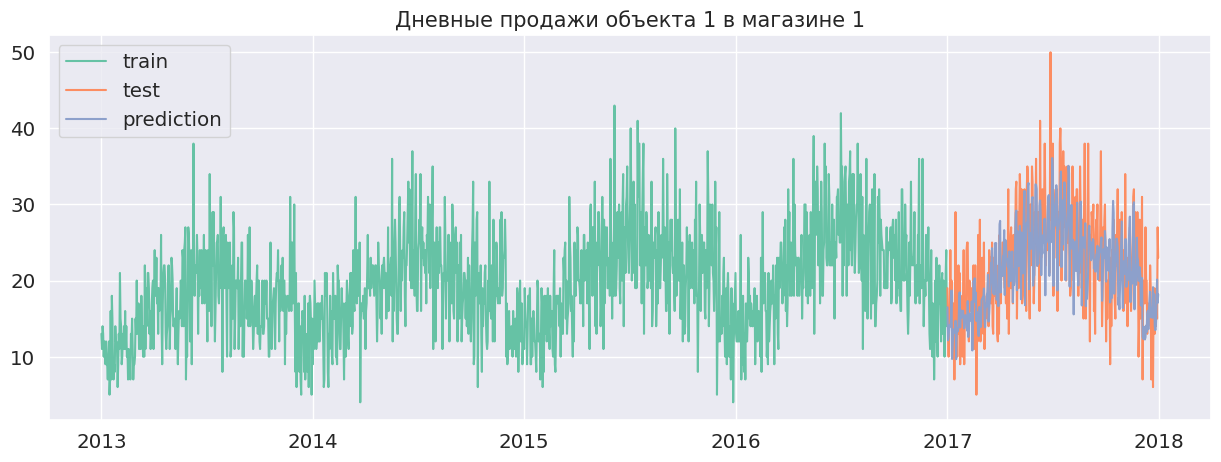

In [22]:
plot_results(data_train, data_test, random_forest_predictions)

Даже по графику уже видно, что модель на тесте стала ближе к реальным данным. Посчитаем метрики.

In [23]:
add_results_in_comparison_table(
    "RandomForest", data_test, random_forest_predictions
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185


Попробуем теперь `CatBoost`.

In [24]:
%%time
catboost_ = CatBoostRegressor()
catboost_.fit(X_train, y_train, verbose=False)

CPU times: user 4.6 s, sys: 1.35 s, total: 5.95 s
Wall time: 560 ms


По умолчанию `CatBoost` использует $1000$ деревьев.

In [25]:
catboost_.tree_count_

1000

In [26]:
catboost_predictions = recursive_prediction(
    catboost_,
    data_test.index,
    data_train,
    lambda date, previous_y: create_date_features(date),
)

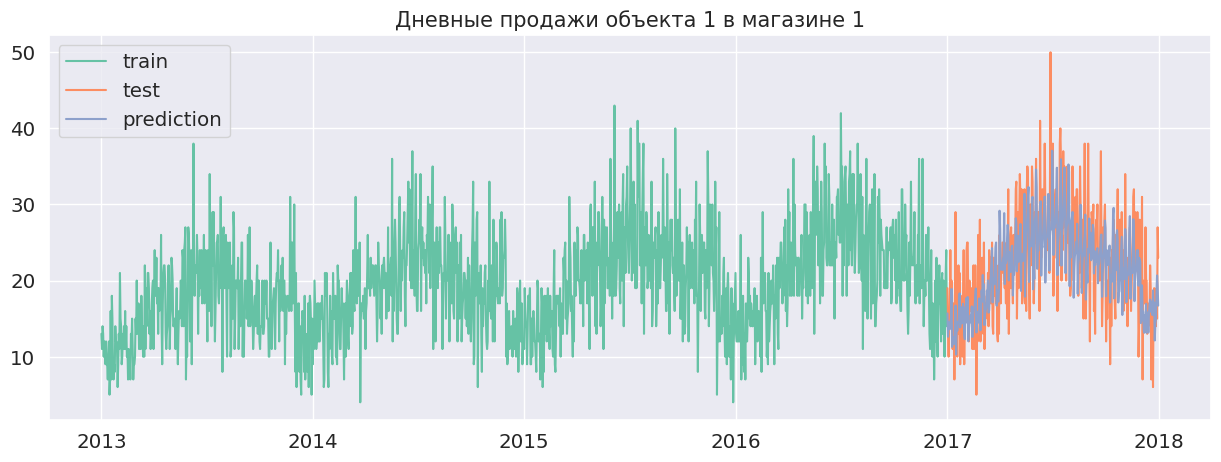

In [27]:
plot_results(data_train, data_test, catboost_predictions)

In [28]:
add_results_in_comparison_table("CatBoost", data_test, catboost_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,CatBoost,25.423261,4.037769,0.207164


### 1.6 Работа с признаками
Поработаем еще с признаками. На этот раз добавим сдвиги по времени. Таким образом модель сможет использовать информацию из прошлого, для составления прогноза на будущее.

In [29]:
def create_date_and_shifted_train_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат
    и значений ряда ранее.
    При этом используются значения ряда со сдвигами
    на неделю и год назад.

    Параметры:
        - y_series
            временной ряд.
        - shifts
            дневной сдвиг.
        - week_seasonal_shifts
            недельный сдвиг.
        - year_seasonal_shifts
            годовой сдвиг.
    """

    curr_df, y = create_only_date_train_features(y_series)
    curr_df.index = y_series.index

    # применяем сдвиг по дням
    for shift in range(1, shifts + 1):
        curr_df[f"shift_{shift}"] = y_series.shift(shift, axis=0)

    # применяем сдвиг по неделям
    for shift in range(1, week_seasonal_shifts + 1):
        curr_df[f"week_seasonal_shift_{shift}"] = y_series.shift(
            shift * 7, axis=0
        )

    # применяем сдвиг по годам
    for shift in range(1, year_seasonal_shifts + 1):
        curr_df[f"year_seasonal_shift_{shift}"] = y_series.shift(
            shift * 365, axis=0
        )
    y = y_series

    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

Также зададим функцию для того, чтобы получать аналогичные признаки на тесте.

In [30]:
def date_and_shift_features_generator_for_test(date, previous_y):
    """Функция создания признаков из дат исдвигов ряда для тестовых дат"""

    row = create_date_features(date)
    for shift in range(1, SHIFT + 1):
        row[f"shift_{shift}"] = previous_y[-1 * shift]
    for shift in range(1, WEEK_SHIFT + 1):
        row[f"week_seasonal_shift_{shift}"] = previous_y[-1 * shift * 7]
    for shift in range(1, YEAR_SHIFT + 1):
        row[f"year_seasonal_shift_{shift}"] = previous_y[-1 * shift * 365]
    return row

Зададим сами сдвиги.

In [31]:
SHIFT = 5  # дневной сдвиг
WEEK_SHIFT = 2  # недельный сдвиг
YEAR_SHIFT = 1  # годовой сдвиг

Получим новые признаки.

In [32]:
X_train, y_train = create_date_and_shifted_train_features(
    data_train,
    shifts=SHIFT,
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT,
)

In [33]:
X_train.head(5)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift_1,shift_2,shift_3,shift_4,shift_5,week_seasonal_shift_1,week_seasonal_shift_2,year_seasonal_shift_1
date,,,,,,,,,,,,,,,
2014-01-01,2,1,1,2014,1,1,1,15.0,5.0,14.0,17.0,18.0,6.0,18.0,13.0
2014-01-02,3,1,1,2014,2,2,1,9.0,15.0,5.0,14.0,17.0,16.0,7.0,11.0
2014-01-03,4,1,1,2014,3,3,1,14.0,9.0,15.0,5.0,14.0,18.0,13.0,14.0
2014-01-04,5,1,1,2014,4,4,1,11.0,14.0,9.0,15.0,5.0,17.0,11.0,13.0
2014-01-05,6,1,1,2014,5,5,1,20.0,11.0,14.0,9.0,15.0,14.0,9.0,10.0


Применим случайный лес к датасету с новыми признаками.

In [34]:
%%time
shifted_features_random_forest = RandomForestRegressor(
    n_estimators=300, random_state=42
)
shifted_features_random_forest.fit(X_train, y_train)

CPU times: user 1.21 s, sys: 1.11 ms, total: 1.21 s
Wall time: 1.21 s


RandomForestRegressor(n_estimators=300, random_state=42)

In [35]:
shifted_features_random_forest_predictions = recursive_prediction(
    shifted_features_random_forest,
    data_test.index,
    data_train,
    date_and_shift_features_generator_for_test,
)

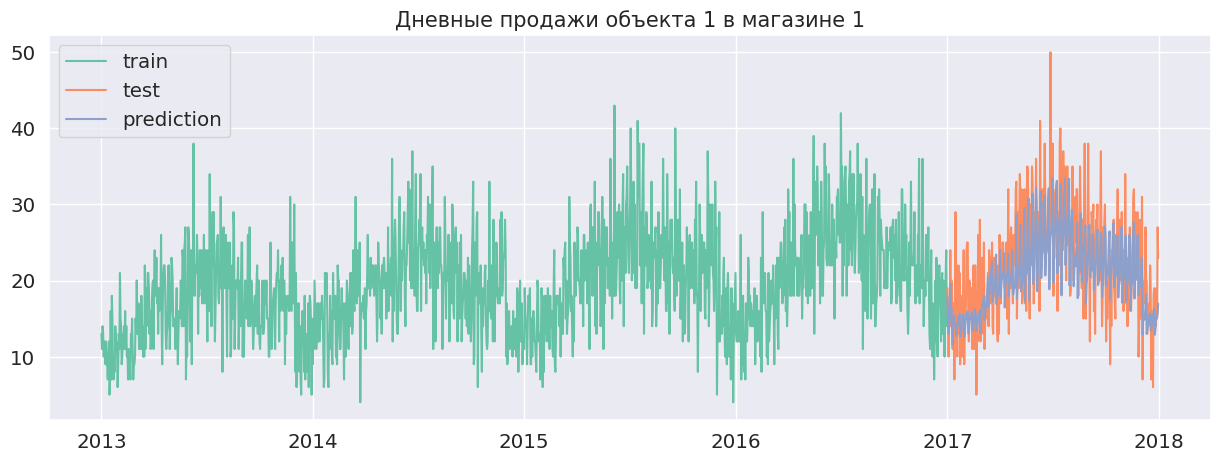

In [36]:
plot_results(
    data_train,
    data_test,
    shifted_features_random_forest_predictions,
)

Тяжело сказать, улучшился результат или нет.

In [37]:
add_results_in_comparison_table(
    "RandomForest + shift features",
    data_test,
    shifted_features_random_forest_predictions,
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,CatBoost,25.423261,4.037769,0.207164
3,RandomForest + shift features,25.826582,4.012575,0.194860


Хотя по графику это не заметно, но результаты модели оказались значительно лучше, чем раньше.

Попробуем снова CatBoost.

In [38]:
%%time
shifted_features_catboost = CatBoostRegressor()
shifted_features_catboost.fit(X_train, y_train, verbose=False)

CPU times: user 4.28 s, sys: 1.44 s, total: 5.72 s
Wall time: 524 ms


In [39]:
shifted_features_ctb_predictions = recursive_prediction(
    shifted_features_catboost,
    data_test.index,
    data_train,
    date_and_shift_features_generator_for_test,
)

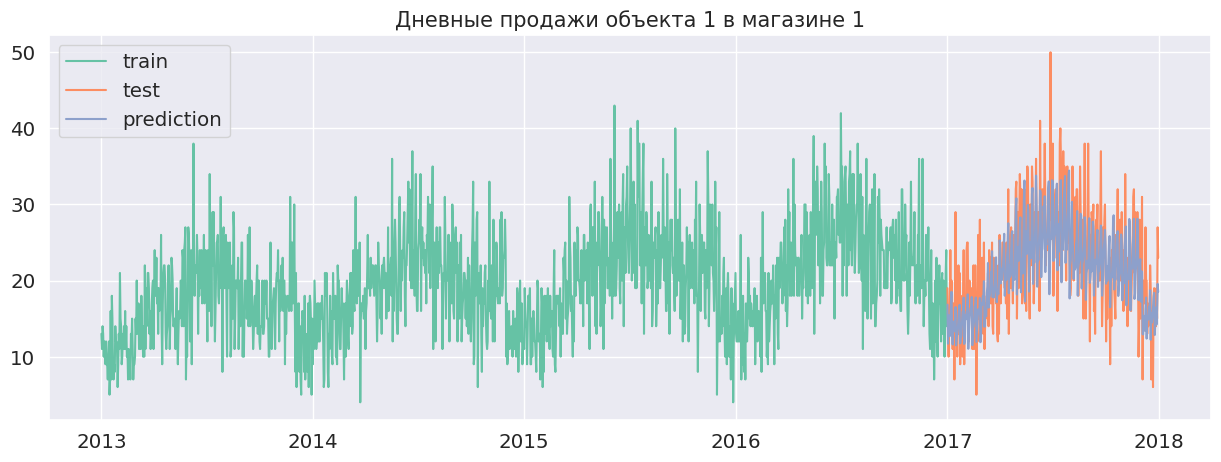

In [40]:
plot_results(
    data_train,
    data_test,
    shifted_features_ctb_predictions,
)

По графику есть ощущение, что CatBoost отработал лучше.

In [41]:
add_results_in_comparison_table(
    "CatBoost + shift features", data_test, shifted_features_ctb_predictions
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,CatBoost,25.423261,4.037769,0.207164
3,RandomForest + shift features,25.826582,4.012575,0.194860
4,CatBoost + shift features,23.919435,3.903062,0.194601


Метрика показывает, что так оно и есть.

### 1.7 Работа с признаками 3
Еще немного поэксперементируем с признаками. На этот раз добавим признаки скользящего среднего.

In [42]:
def create_date_shifted_and_rolling_train_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат
    и значений ряда ранее.
    Используются занчения ряда со сдвигами на неделю и год назад.
    Также добавлены признаки скользящего среднего.

    Параметры:
        - y_series
            временной ряд.
        - shifts
            дневной сдвиг.
        - week_seasonal_shifts
            недельный сдвиг.
        - year_seasonal_shifts
            годовой сдвиг.
    """

    curr_df, y = create_date_and_shifted_train_features(
        y_series,
        shifts=shifts,
        week_seasonal_shifts=week_seasonal_shifts,
        year_seasonal_shifts=year_seasonal_shifts,
    )

    # Важно! значения скользящего окна надо сдивнуть на 1 вправо,
    # иначе вы будете использовать при обучении текущее значение ряда.
    curr_df["rolling_mean"] = (
        y_series.rolling(shifts, min_periods=1).mean().shift(1, axis=0)
    )
    curr_df["rolling_max"] = (
        y_series.rolling(shifts, min_periods=1).max().shift(1, axis=0)
    )
    curr_df["rolling_min"] = (
        y_series.rolling(shifts, min_periods=1).min().shift(1, axis=0)
    )

    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

In [43]:
def date_shifted_and_rolling_features_generator_for_test(date, previous_y):
    """Функция создания признаков из дат исдвигов ряда для тестовых дат"""

    row = date_and_shift_features_generator_for_test(date, previous_y)
    row["rolling_mean"] = np.mean(previous_y[-SHIFT:])
    row["rolling_max"] = np.max(previous_y[-SHIFT:])
    row["rolling_min"] = np.min(previous_y[-SHIFT:])
    return row

Получим новые признаки.

In [44]:
X_train, y_train = create_date_shifted_and_rolling_train_features(
    data_train,
    shifts=SHIFT,
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT,
)

Применим случайный лес к датасету с новыми признаками.

In [45]:
advanced_features_random_forest = RandomForestRegressor(
    n_estimators=300, random_state=42
)
advanced_features_random_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [46]:
advanced_features_random_forest_predictions = recursive_prediction(
    advanced_features_random_forest,
    data_test.index,
    data_train,
    date_shifted_and_rolling_features_generator_for_test,
)

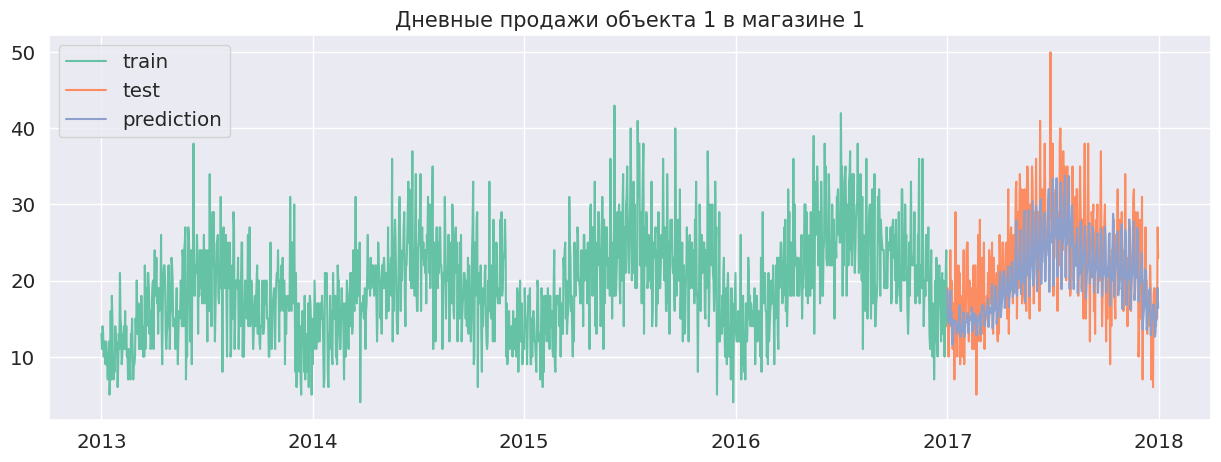

In [47]:
plot_results(
    data_train,
    data_test,
    advanced_features_random_forest_predictions,
)

In [48]:
add_results_in_comparison_table(
    "RandomForest, advanced features",
    data_test,
    advanced_features_random_forest_predictions,
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,CatBoost,25.423261,4.037769,0.207164
3,RandomForest + shift features,25.826582,4.012575,0.194860
4,CatBoost + shift features,23.919435,3.903062,0.194601
5,"RandomForest, advanced features",26.147727,4.039598,0.193977


Применим теперь `CatBoost` к датасету с новыми признаками.

In [49]:
advanced_features_catboost = CatBoostRegressor()
advanced_features_catboost.fit(X_train, y_train, verbose=False)

In [50]:
advanced_features_ctb_predictions = recursive_prediction(
    advanced_features_catboost,
    data_test.index,
    data_train,
    date_shifted_and_rolling_features_generator_for_test,
)

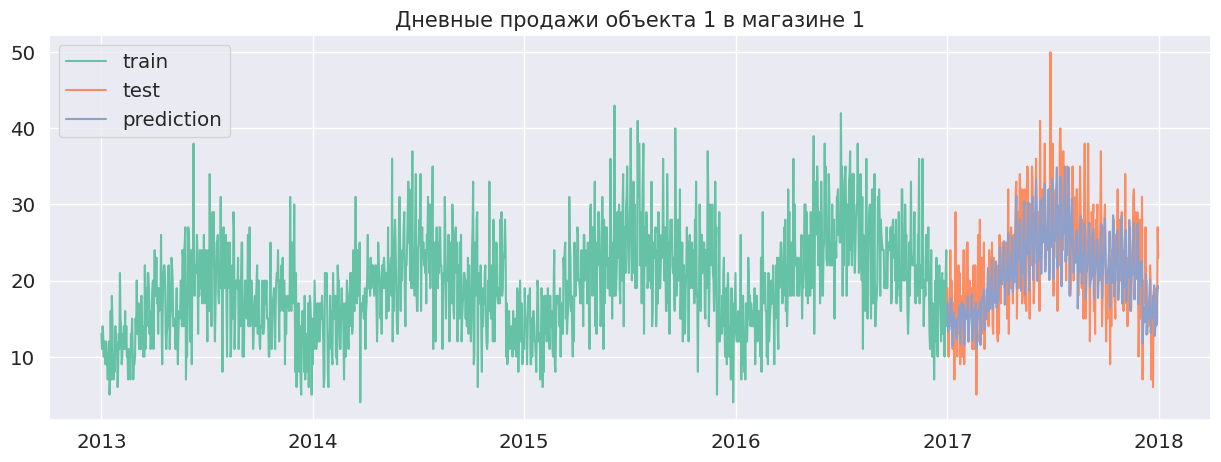

In [51]:
plot_results(
    data_train,
    data_test,
    advanced_features_ctb_predictions,
)

In [52]:
add_results_in_comparison_table(
    "CatBoost, advanced features", data_test, advanced_features_ctb_predictions
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,CatBoost,25.423261,4.037769,0.207164
3,RandomForest + shift features,25.826582,4.012575,0.194860
4,CatBoost + shift features,23.919435,3.903062,0.194601
5,"RandomForest, advanced features",26.147727,4.039598,0.193977
6,"CatBoost, advanced features",23.928391,3.910230,0.193050


Добавление более сложных признаков не помогло CatBoost лучше обучиться.

### 1.8 Подбор гиперпараметров

Подберем гиперпараметры для `CatBoost + shift features`

In [53]:
X_train, y_train = create_date_and_shifted_train_features(
    data_train,
    shifts=SHIFT,
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT,
)

In [54]:
# Задаем сетку параметров
random_grid = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 400, 600, 800, 1000, 1200],
}

In [55]:
cv = [
    [np.arange(0, 365), np.arange(365, 365 * 2)],
    [np.arange(0, 365 * 2), np.arange(365 * 2, 365 * 3)],
]

Используем `RandomizedSearchCV` для подбора гиперпараметров.

In [56]:
ctb = CatBoostRegressor(verbose=False)
ctb_random = RandomizedSearchCV(
    estimator=ctb,
    param_distributions=random_grid,
    n_iter=100,
    cv=cv,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=4,
    verbose=False,
)

In [57]:
ctb_random.fit(X_train, y_train)
ctb_random.best_params_

/home/work/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/work/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 200, 'learning_rate': 0.05, 'depth': 4}

Построим предсказания модели с лучшими гиперпараметрами.

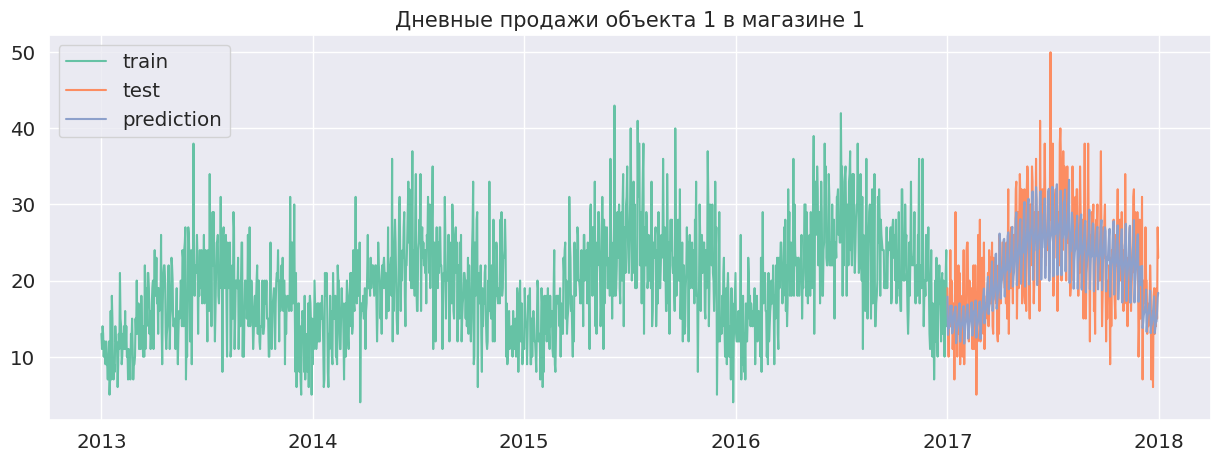

In [58]:
cv_shifted_features_catboost = ctb_random.best_estimator_
cv_shifted_features_catboost_predictions = recursive_prediction(
    cv_shifted_features_catboost,
    data_test.index,
    data_train,
    date_and_shift_features_generator_for_test,
)
plot_results(
    data_train,
    data_test,
    cv_shifted_features_catboost_predictions,
)

Сравним результаты подобранной модели.

In [59]:
add_results_in_comparison_table(
    "CatBoost + shift features + cv",
    data_test,
    cv_shifted_features_catboost_predictions,
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,CatBoost,25.423261,4.037769,0.207164
3,RandomForest + shift features,25.826582,4.012575,0.194860
4,CatBoost + shift features,23.919435,3.903062,0.194601
5,"RandomForest, advanced features",26.147727,4.039598,0.193977
6,"CatBoost, advanced features",23.928391,3.910230,0.193050
7,CatBoost + shift features + cv,23.254015,3.835524,0.193311


### Prophet

In [60]:
df_train = pd.DataFrame({'ds' : y_train.index, 'y': y_train.values})
df_test = pd.DataFrame({'ds' : data_test.index, 'y': data_test.values})

In [61]:
model = Prophet()

In [62]:
model.fit(df_train)

11:01:07 - cmdstanpy - INFO - Chain [1] start processing
11:01:07 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
forecast = model.predict(df_test)

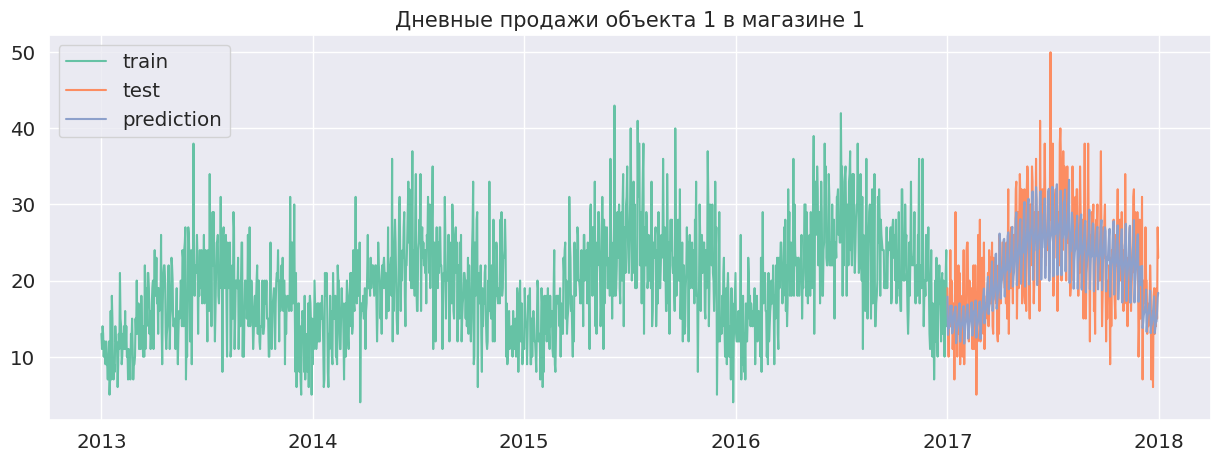

In [72]:
plot_results(
    data_train,
    data_test,
    cv_shifted_features_catboost_predictions,
)

In [73]:
add_results_in_comparison_table(
    "Prophet", data_test, forecast['yhat']
)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,CatBoost,25.423261,4.037769,0.207164
3,RandomForest + shift features,25.826582,4.012575,0.194860
4,CatBoost + shift features,23.919435,3.903062,0.194601
5,"RandomForest, advanced features",26.147727,4.039598,0.193977
6,"CatBoost, advanced features",23.928391,3.910230,0.193050
7,CatBoost + shift features + cv,23.254015,3.835524,0.193311
8,Prophet,24.185954,3.985510,0.217519


### ARIMA, TBATS